In [30]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd

## Import Dataset

In [31]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_reverse_split_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [32]:
train_dataset = FingerprintDataset(split='train')
test_dataset = FingerprintDataset(split='test')

In [33]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [34]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = best_config.GLOBALPARAMETERS['valid_size']

In [35]:
#Get Model Parameters
hyperparameters = eval('best_config.'+'MLP_MCDO'+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

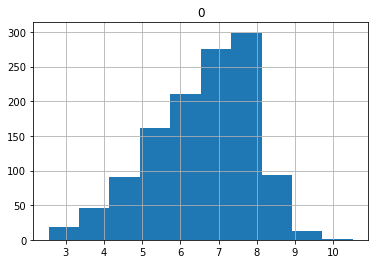

In [36]:
train_df= pd.DataFrame(train_dataset.y.cpu().tolist())
#train_df.applymap(lambda x: x[0])
train_df.hist()

## Define Model

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [38]:
model_params

{'has_edge_info': False,
 'batch_size': 16,
 'learning_rate': 0.0002007339899573065,
 'model_layers': 2,
 'model_embedding_size': 256,
 'model_dense_neurons': 256,
 'model_linear_dropout_rate': 0.05,
 'model_embedding_dropout_rate': 0.05,
 'feature_size': 1024}

In [39]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+'MLP_REGRESSION'+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP_REGRESSION(
  (conv_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (initial_conv): Linear(in_features=1024, out_features=256, bias=True)
  (embedding_dropout): Dropout(p=0.05, inplace=False)
  (linear_dropout): Dropout(p=0.05, inplace=False)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)
394753


In [40]:
model = model.to(device)

In [41]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=0.000001)  

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [42]:
class Engine:
    def __init__(self, model, model_params, optimizer, device):
        self.model = model
        self.model_params = model_params
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = torch.nn.MSELoss()

    def train(self, loader):
        self.model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            self.optimizer.zero_grad()
            fingerprint = fingerprint.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            mu = self.model(fingerprint)
            loss = self.loss_fn(mu, labels)
            # Backward and optimize
            final_loss += loss.item()
            loss.backward()
            self.optimizer.step() 
        return final_loss / len(loader)
    
    def evaluate(self, loader):
            self.model.eval()
            # Enumerate over the data
            final_loss = 0
            for i, (fingerprint, labels) in enumerate(loader):  
                fingerprint = fingerprint.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                mu = self.model(fingerprint)
                loss = self.loss_fn(mu, labels)
                final_loss += loss.item()
            return final_loss / len(loader)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

eng = Engine(model, model_params, optimizer, device)

print("Starting training...")
losses = []
for epoch in range(no_of_epochs):
    loss = eng.train(train_loader)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 18.405886127760535
Epoch 10 | Train Loss 0.2678776789260538
Epoch 20 | Train Loss 0.18680818991637543
Epoch 30 | Train Loss 0.1317868880241325
Epoch 40 | Train Loss 0.1215555283093923
Epoch 50 | Train Loss 0.1088424626933901
Epoch 60 | Train Loss 0.1055427210307435
Epoch 70 | Train Loss 0.11807585125298876
Epoch 80 | Train Loss 0.1195209702770961
Epoch 90 | Train Loss 0.11496547119397867
Epoch 100 | Train Loss 0.09841107809916139
Epoch 110 | Train Loss 0.09572310125651329
Epoch 120 | Train Loss 0.09400435154767413
Epoch 130 | Train Loss 0.10321950022817443
Epoch 140 | Train Loss 0.11163617165661172
Epoch 150 | Train Loss 0.09259100799987975
Epoch 160 | Train Loss 0.09361731437476058
Epoch 170 | Train Loss 0.09423124670100055
Epoch 180 | Train Loss 0.08521131798624992
Epoch 190 | Train Loss 0.0935509018845072


## Evaluate on the Test Set

In [44]:
import pandas as pd
model.eval()
true_values = []
predictions = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        mu = model(fingerprint)
        true_values += labels.tolist()
        predictions += mu.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
df = df.applymap(lambda x : x[0])
df

,y_pred,y_real
0,6.808861,7.148742
1,4.847393,4.000000
2,4.312698,4.850781
3,7.051374,7.221849
4,6.272474,6.886056
...,...,...
298,3.818512,3.943095
299,6.748466,7.060481
300,7.441253,6.920819
301,8.361559,8.045757


In [45]:
df = pd.DataFrame({
      "y_pred": [],
      'y_real':[],
      'variance':[],
      })
for fingerprint, label in test_loader:
      fingerprint = fingerprint.to(device)
      samples = 100
      model.train()
      preds = [model(fingerprint) for i in range(samples)]
      preds = torch.stack(preds)
      preds = preds.cpu()
      means = preds.mean(axis=0).detach().numpy()
      stds =  preds.std(axis=0).detach().numpy()
      label = label.detach().numpy()
      means, stds
      y_vals = [label, means, stds]
      data = {
            "y_pred": list(y_vals[0].squeeze()),
            'y_real': list(y_vals[1].squeeze()),
            "variance": list(y_vals[2].squeeze())
            }
      data = pd.DataFrame(data)
      df = df.append(pd.DataFrame(data))
df = df.sort_values('y_real').reset_index(drop=True)
df

,y_pred,y_real,variance
0,3.370590,2.977298,0.090482
1,3.113509,3.053144,0.095061
2,3.767004,3.392007,0.103414
3,2.953115,3.515237,0.117086
4,3.886057,3.521885,0.119541
...,...,...,...
298,8.958608,8.658302,0.285906
299,8.721247,8.697102,0.271274
300,7.853872,8.707878,0.269590
301,8.698970,8.912098,0.288108


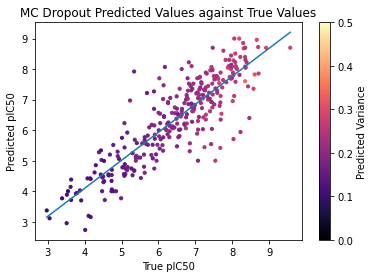

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data...
x = df["y_real"]
y = df["y_pred"]
color = df['variance']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

sc = plt.scatter(x, y, c=color, s=10, cmap='magma')
cbar = plt.colorbar(sc)
cbar.set_label('Predicted Variance')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('MC Dropout Predicted Values against True Values')
plt.clim(0, 0.5) 
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/pvtMCDO.jpeg', bbox_inches = 'tight', dpi=300)

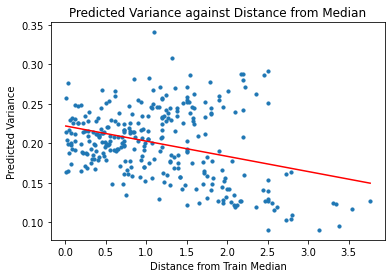

In [47]:
x = abs(df['y_pred']-6.5)
y = df['variance']

plt.scatter(x,y, s=10)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='r')
plt.xlabel('Distance from Train Median')
plt.ylabel('Predicted Variance')
plt.title('Predicted Variance against Distance from Median')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/varvtMCDO.jpeg', bbox_inches = 'tight', dpi=300)

In [48]:
df['y_pred_dist'] = abs(df['y_pred']-6.5)

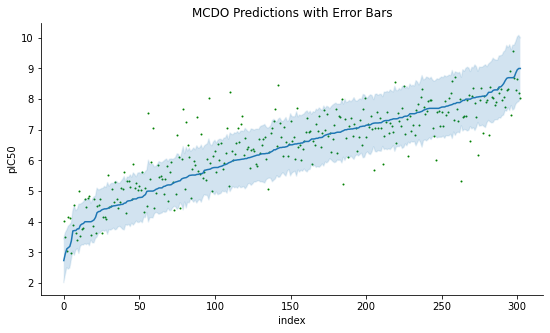

In [49]:
import matplotlib.pyplot as plt

df = df.sort_values('y_pred').reset_index(drop=True)

x = df.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
mu = df['y_pred']
error = 2*(df['variance']**0.5)
lower = mu - error
upper = mu + error

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, df['y_real'], label='pred mean', color='g', s=1)
ax.plot(x, mu, label='pred mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('index')
ax.set_ylabel('pIC50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('MCDO Predictions with Error Bars')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/MCDOerrbar.jpeg', bbox_inches = 'tight', dpi=300)

In [50]:
from sklearn import metrics
from scipy.stats import stats
df['y_pred_dist'] = abs(df['y_pred']-6.5)

def get_results(df):
    mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
    sc = stats.spearmanr(df["y_real"],df["y_pred"])[0]
    pc = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
    r = metrics.r2_score(df["y_real"],df["y_pred"])
    varcorr = np.corrcoef(df['y_pred_dist'], df['variance'])[0,1]

    results = {
        'Mean Square Error':mse,
        'Spearman':sc,
        'Pearson':pc,
        'R':r,
        'Variance Rho': varcorr,
    }
    results_df = pd.DataFrame([results])
    return results_df

get_results(df).to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/MCDOresults.csv')
get_results(df)

,Mean Square Error,Spearman,Pearson,R,Variance Rho
0,0.486165,0.845231,0.869632,0.714605,-0.332255
